# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели. 

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def onehot_encoding(x):
    a = []
    for i in sorted(set(x)):
        a.append(x == i)
    return np.array(a).T


def minmax_scale(x):
    if len(np.unique(x)) == 1:
        return np.zeros(x.shape)
    x_std = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    return x_std

In [16]:
#Импорт датасета
data =  pd.read_csv("travel insurance.csv")

#столбец Gender стоит удалить, так как он состоит из 71% пропущенных значений
#столбец Distribution Channel тоже стоит удалить, так как он состоит из 98% одинаковых значений Online
data=data.drop(columns=["Gender","Distribution Channel"])

In [17]:
from sklearn.utils import resample
#Удалим повторяющиеся значения target. Так как здесь присутствует жёсткий дисбаланс классов, то линейная модель скорее всего плохо обучится
# Пусть классов No, чтобы модель могла примерно нормально обучиться

df_majority = data[data["Claim"] == "No"]
df_minority = data[data["Claim"] == "Yes"]

df_majority_downsampled = resample(df_majority,replace=False,n_samples=1500,random_state=42)

data=pd.concat([df_majority_downsampled,df_minority])
y=np.array(data["Claim"])[:,np.newaxis]
data=data.drop(columns="Claim")

In [18]:
cat_features = data.select_dtypes(include="object").columns
num_features = data.select_dtypes(include=["int64","float64"]).columns

#Группируем редко встречающиеся значения в категориальных признаках
for i in cat_features:
    for j in np.unique(data[i]):
        if data[i].value_counts()[j]<400:
            data.loc[data[i]==j,i]="other"

In [19]:
data["Product Name"].value_counts().index

Index(['other', 'Cancellation Plan', '2 way Comprehensive Plan'], dtype='object', name='Product Name')

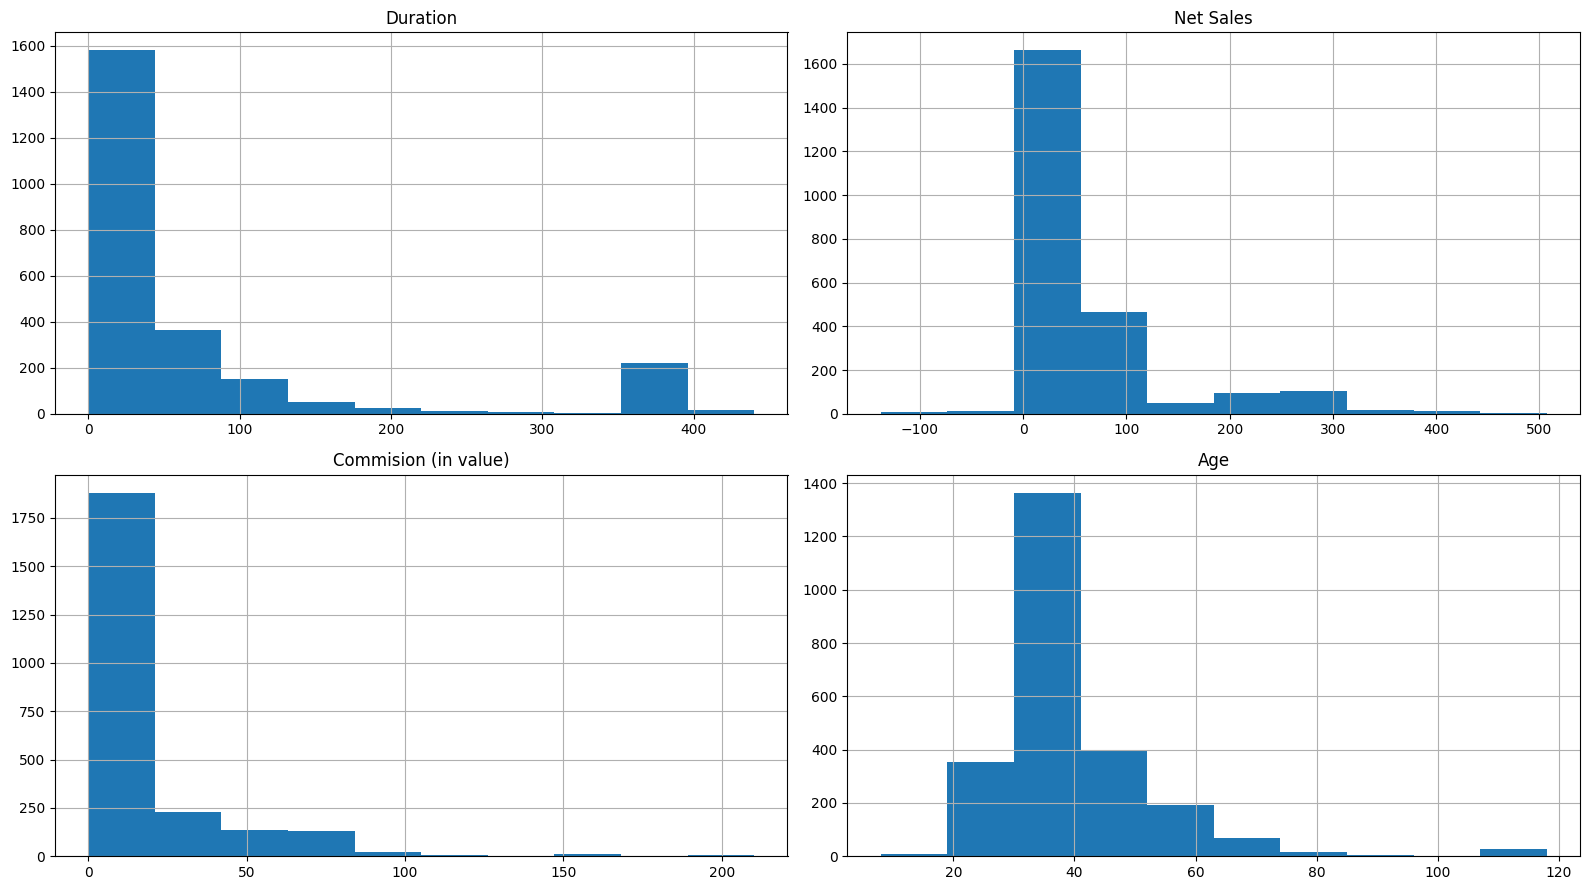

Index(['Agency', 'Agency Type', 'Product Name', 'Destination'], dtype='object') Index(['Duration', 'Net Sales', 'Commision (in value)', 'Age'], dtype='object')


In [20]:
plt.figure(figsize=(16,9))
i=0
for j in num_features:
    i+=1
    plt.subplot(2,2,i)
    plt.title(j)
    data[j].hist()
plt.tight_layout()
plt.show()
print(cat_features,num_features)

In [21]:
#Убираем выбросы в числовых признаках, заполним выбросы средним значением (жалко удалять)
#Удалим отрицательное количество дней и выбросы в кол-ве днях
data.loc[(data["Duration"]>280)|(data["Duration"]<0),"Duration"]=data["Duration"].mean()
data.loc[(data["Net Sales"]>190)|(data["Net Sales"]<0),"Net Sales"]=data["Net Sales"].mean()
data.loc[(data["Commision (in value)"]>50),"Commision (in value)"]=data["Commision (in value)"].mean()
data.loc[(data["Age"]>100),"Age"]=data["Age"].mean()

C:\Users\dartm\AppData\Local\Temp\ipykernel_5872\2024545379.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.7338277709106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data["Duration"]>280)|(data["Duration"]<0),"Duration"]=data["Duration"].mean()
C:\Users\dartm\AppData\Local\Temp\ipykernel_5872\2024545379.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.31025957972806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data["Age"]>100),"Age"]=data["Age"].mean()


In [22]:
one_cat_features = pd.DataFrame(np.hstack([onehot_encoding(data[i]) for i in cat_features])).astype("int64")
normalize_num_features = pd.DataFrame(np.vstack([minmax_scale(data[i]) for i in num_features]).reshape(data.shape[0],-1))

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [23]:
from sklearn.model_selection import train_test_split

y=np.where(y=="Yes",1,0)
X=pd.concat([pd.DataFrame(np.ones([normalize_num_features.shape[0],1])),normalize_num_features,one_cat_features],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [24]:
# посчитайте аналитическое решение
class DummyLinearRegression:
    def fit(self, X, y):
        self.w = (np.linalg.inv(X.T @ X) @ X.T @ y).to_numpy()
        return self
        
    def predict(self, X):
        y_pred = X @ self.w
        y_pred_scaled = minmax_scale(y_pred)
        y_pred_binary = np.where(y_pred_scaled >= 0.5, 1, 0)
        return y_pred_binary
    
    def get_weights(self):
        return self.w
y_train = y_train.reshape(-1, 1)
model1=DummyLinearRegression()
model1.fit(X_train,y_train)

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

y_pred=model1.predict(X_test)
print(mean_squared_error(y_pred=y_pred,y_true=y_test))
print(classification_report(y_pred=y_pred,y_true=y_test))
print(r2_score(y_pred=y_pred,y_true=y_test))

0.2345679012345679
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       300
           1       0.74      0.60      0.66       186

    accuracy                           0.77       486
   macro avg       0.76      0.73      0.74       486
weighted avg       0.76      0.77      0.76       486

0.007096774193548816


In [26]:
# посчитать аналитическое решение с регуляризацией
class DummyLinearRegressionWithRegularization:
    def fit(self, X, y,l):
        self.w = (np.linalg.inv(X.T @ X+l*np.eye(X.shape[1])) @ X.T @ y).to_numpy()
        return self
        
    def predict(self, X):
        y_pred = X @ self.w
        y_pred_scaled = minmax_scale(y_pred)
        y_pred_binary = np.where(y_pred_scaled >= 0.4, 1, 0)
        return y_pred_binary
    
    def get_weights(self):
        return self.w
model_l2=DummyLinearRegressionWithRegularization()
model_l2.fit(X_train,y_train,9)

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [29]:
y_pred=model_l2.predict(X_test)
print(mean_squared_error(y_pred=y_pred,y_true=y_test))
print(classification_report(y_pred=y_pred,y_true=y_test))
print(r2_score(y_pred=y_pred,y_true=y_test))

0.21193415637860083
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       300
           1       0.74      0.69      0.71       186

    accuracy                           0.79       486
   macro avg       0.78      0.77      0.77       486
weighted avg       0.79      0.79      0.79       486

0.10290322580645206


In [47]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred = np.where(y_pred >= 0.4, 1, 0)
print(mean_squared_error(y_pred=y_pred,y_true=y_test))
print(classification_report(y_pred=y_pred,y_true=y_test))
print(r2_score(y_pred=y_pred,y_true=y_test))

0.205761316872428
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       300
           1       0.70      0.81      0.75       186

    accuracy                           0.79       486
   macro avg       0.78      0.80      0.79       486
weighted avg       0.80      0.79      0.80       486

0.12903225806451657


In [43]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train,y_train)
y_pred=ridge.predict(X_test)
y_pred = np.where(y_pred >= 0.4, 1, 0)
print(mean_squared_error(y_pred=y_pred,y_true=y_test))
print(classification_report(y_pred=y_pred,y_true=y_test))
print(r2_score(y_pred=y_pred,y_true=y_test))

0.205761316872428
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       300
           1       0.70      0.81      0.75       186

    accuracy                           0.79       486
   macro avg       0.78      0.80      0.79       486
weighted avg       0.80      0.79      0.80       486

0.12903225806451657


### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

В этом задании был проанализирован датасет, преобразование фичей, также было обучение обычной линейной регрессии и линейной регрессии с регуляризацией. 

Для кодирования кат. признаков был выбран ohe, так как линейная регрессия хорошо подходит для него. Если у нас j признак принимает какое-то значение i, то каждому i значению соответствует свой вес. Количество признаков было 15, а это не так много

Для кодирования числовых признаков была применена нормализация значений по мин-макс (такое техническое требование).

Обычная модель на MSE показала 0.23, а с регуляризацией 0.21. Можно константировать что линейная модель с регуляризацией работает лучше. Для линейной модели результат скорее всего неплохой